<h2>Урок 8 - Сегментация<h2/>

<h3>Brain MRI segmentation<h3/>

https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [2]:
import cv2
import pandas as pd

In [3]:
data = pd.read_csv('./Brain MRI segmentation/kaggle_3m/data.csv')
data

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,NaN,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,NaN,5.0,2,1.0,NaN,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,NaN,5.0,2,NaN,NaN,NaN,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [4]:
data = data.fillna(-1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              110 non-null    float64
 2   MethylationCluster         110 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  110 non-null    float64
 5   RPPACluster                110 non-null    float64
 6   OncosignCluster            110 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          110 non-null    float64
 9   neoplasm_histologic_grade  110 non-null    float64
 10  tumor_tissue_site          110 non-null    float64
 11  laterality                 110 non-null    float64
 12  tumor_location             110 non-null    float64
 13  gender                     110 non-null    float64

In [6]:
PAHT = '.\Brain MRI segmentation\kaggle_3m'

In [7]:
import os, fnmatch
dirs = os.listdir(PAHT)
dirs

['data.csv',
 'README.md',
 'TCGA_CS_4941_19960909',
 'TCGA_CS_4942_19970222',
 'TCGA_CS_4943_20000902',
 'TCGA_CS_4944_20010208',
 'TCGA_CS_5393_19990606',
 'TCGA_CS_5395_19981004',
 'TCGA_CS_5396_20010302',
 'TCGA_CS_5397_20010315',
 'TCGA_CS_6186_20000601',
 'TCGA_CS_6188_20010812',
 'TCGA_CS_6290_20000917',
 'TCGA_CS_6665_20010817',
 'TCGA_CS_6666_20011109',
 'TCGA_CS_6667_20011105',
 'TCGA_CS_6668_20011025',
 'TCGA_CS_6669_20020102',
 'TCGA_DU_5849_19950405',
 'TCGA_DU_5851_19950428',
 'TCGA_DU_5852_19950709',
 'TCGA_DU_5853_19950823',
 'TCGA_DU_5854_19951104',
 'TCGA_DU_5855_19951217',
 'TCGA_DU_5871_19941206',
 'TCGA_DU_5872_19950223',
 'TCGA_DU_5874_19950510',
 'TCGA_DU_6399_19830416',
 'TCGA_DU_6400_19830518',
 'TCGA_DU_6401_19831001',
 'TCGA_DU_6404_19850629',
 'TCGA_DU_6405_19851005',
 'TCGA_DU_6407_19860514',
 'TCGA_DU_6408_19860521',
 'TCGA_DU_7008_19830723',
 'TCGA_DU_7010_19860307',
 'TCGA_DU_7013_19860523',
 'TCGA_DU_7014_19860618',
 'TCGA_DU_7018_19911220',
 'TCGA_DU_7

In [8]:
dic = dict()
lst = []
for di in dirs:
    if '.' not in di:
        imgs = os.listdir(f'{PAHT}\\{di}')
        d = dict()
        for img in imgs:
            s = img.replace(di + '_', '').split('_')
            num = s[0].split('.')[0]
            if num in d.keys():
                d[num].append(img)
            else:
                d[num] = [img]        
        for key in d.keys():
            if len(d[key]) > 1:
                name = '_'.join(di.split('_')[:-1])                
                lst.append([name, di, key, d[key][0], d[key][1]])
        dic[di] = d
df = pd.DataFrame(lst)
df.columns =['Patient', 'FullId','img_id','img', 'img_mask']
df

,Patient,FullId,img_id,img,img_mask
0,TCGA_CS_4941,TCGA_CS_4941_19960909,1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif
1,TCGA_CS_4941,TCGA_CS_4941_19960909,10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif
2,TCGA_CS_4941,TCGA_CS_4941_19960909,11,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif
3,TCGA_CS_4941,TCGA_CS_4941_19960909,12,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif
4,TCGA_CS_4941,TCGA_CS_4941_19960909,13,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif
...,...,...,...,...,...
3924,TCGA_HT_A61B,TCGA_HT_A61B_19991127,85,TCGA_HT_A61B_19991127_85.tif,TCGA_HT_A61B_19991127_85_mask.tif
3925,TCGA_HT_A61B,TCGA_HT_A61B_19991127,86,TCGA_HT_A61B_19991127_86.tif,TCGA_HT_A61B_19991127_86_mask.tif
3926,TCGA_HT_A61B,TCGA_HT_A61B_19991127,87,TCGA_HT_A61B_19991127_87.tif,TCGA_HT_A61B_19991127_87_mask.tif
3927,TCGA_HT_A61B,TCGA_HT_A61B_19991127,88,TCGA_HT_A61B_19991127_88.tif,TCGA_HT_A61B_19991127_88_mask.tif


In [9]:
data

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,-1.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,-1.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,-1.0,0.0
3,TCGA_CS_4944,-1.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,-1.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,-1.0,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,-1.0,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,-1.0,5.0,2,1.0,-1.0,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,-1.0,5.0,2,-1.0,-1.0,-1.0,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


In [10]:
df.columns

Index(['Patient', 'FullId', 'img_id', 'img', 'img_mask'], dtype='object')

In [11]:
data.columns

Index(['Patient', 'RNASeqCluster', 'MethylationCluster', 'miRNACluster',
       'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster',
       'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site',
       'laterality', 'tumor_location', 'gender', 'age_at_initial_pathologic',
       'race', 'ethnicity', 'death01'],
      dtype='object')

In [12]:
info = df.merge(data, left_on='Patient', right_on='Patient')
info

,Patient,FullId,img_id,img,img_mask,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,...,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,TCGA_CS_4941_19960909,1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,2.0,4.0,2,2.0,-1.0,...,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4941,TCGA_CS_4941_19960909,10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,2.0,4.0,2,2.0,-1.0,...,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
2,TCGA_CS_4941,TCGA_CS_4941_19960909,11,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,2.0,4.0,2,2.0,-1.0,...,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
3,TCGA_CS_4941,TCGA_CS_4941_19960909,12,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif,2.0,4.0,2,2.0,-1.0,...,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
4,TCGA_CS_4941,TCGA_CS_4941_19960909,13,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif,2.0,4.0,2,2.0,-1.0,...,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,TCGA_HT_A61B,TCGA_HT_A61B_19991127,85,TCGA_HT_A61B_19991127_85.tif,TCGA_HT_A61B_19991127_85_mask.tif,-1.0,5.0,2,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3925,TCGA_HT_A61B,TCGA_HT_A61B_19991127,86,TCGA_HT_A61B_19991127_86.tif,TCGA_HT_A61B_19991127_86_mask.tif,-1.0,5.0,2,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3926,TCGA_HT_A61B,TCGA_HT_A61B_19991127,87,TCGA_HT_A61B_19991127_87.tif,TCGA_HT_A61B_19991127_87_mask.tif,-1.0,5.0,2,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3927,TCGA_HT_A61B,TCGA_HT_A61B_19991127,88,TCGA_HT_A61B_19991127_88.tif,TCGA_HT_A61B_19991127_88_mask.tif,-1.0,5.0,2,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
info = info.drop(['Patient', 'FullId', 'img_id', 'img', 'img_mask'], axis=1)

In [14]:
df

,Patient,FullId,img_id,img,img_mask
0,TCGA_CS_4941,TCGA_CS_4941_19960909,1,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif
1,TCGA_CS_4941,TCGA_CS_4941_19960909,10,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif
2,TCGA_CS_4941,TCGA_CS_4941_19960909,11,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif
3,TCGA_CS_4941,TCGA_CS_4941_19960909,12,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif
4,TCGA_CS_4941,TCGA_CS_4941_19960909,13,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif
...,...,...,...,...,...
3924,TCGA_HT_A61B,TCGA_HT_A61B_19991127,85,TCGA_HT_A61B_19991127_85.tif,TCGA_HT_A61B_19991127_85_mask.tif
3925,TCGA_HT_A61B,TCGA_HT_A61B_19991127,86,TCGA_HT_A61B_19991127_86.tif,TCGA_HT_A61B_19991127_86_mask.tif
3926,TCGA_HT_A61B,TCGA_HT_A61B_19991127,87,TCGA_HT_A61B_19991127_87.tif,TCGA_HT_A61B_19991127_87_mask.tif
3927,TCGA_HT_A61B,TCGA_HT_A61B_19991127,88,TCGA_HT_A61B_19991127_88.tif,TCGA_HT_A61B_19991127_88_mask.tif


In [15]:
h1 = 256
w1 = 256

In [16]:
imgs = []
label = []
for e in df.values:
    imgs.append(e[2])
images = []
segments = []
image_size = (h1,w1)
for i_name in df.values:
    images.append(image.load_img(PAHT + '\\' + i_name[1] + '\\' + i_name[3], target_size=image_size))
    segments.append(image.load_img(PAHT + '\\' + i_name[1] + '\\' + i_name[4], target_size=image_size))

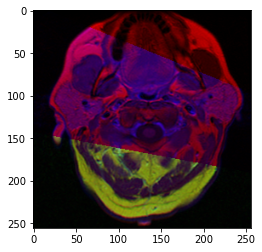

In [17]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

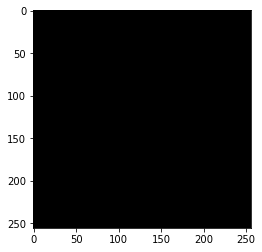

In [18]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [19]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [20]:
print(xTrain_Test.shape)

(3929, 256, 256, 3)


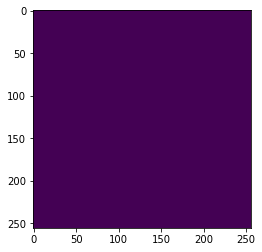

In [21]:
def Color2index(y):
  arr_col=[[255,255,255]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

In [22]:
np.sum(cat_yi[100:,:100,0])

0.0

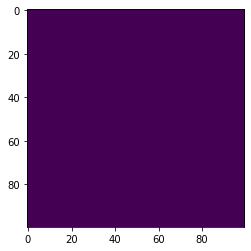

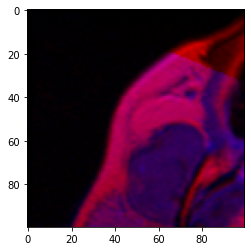

In [23]:
plt.imshow(cat_yi[:100,:100,0])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [24]:
cat_yi.shape

(256, 256, 1)

In [25]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

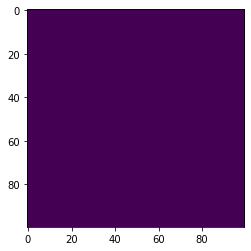

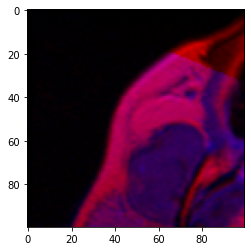

In [26]:
plt.imshow(cat_yi[:100,:100,0])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [27]:
print(yTrain_Test.shape)

(3929, 256, 256, 1)


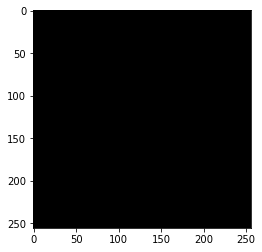

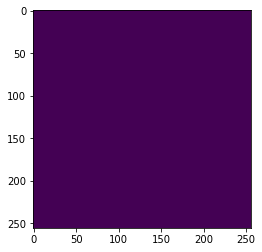

In [28]:
n = 0
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

In [29]:
N = int(yTrain_Test.shape[0] - yTrain_Test.shape[0] * 0.2)
N

3143

In [30]:
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [31]:
y_train = np.array([int(np.sum(e) > 0.01) for e in yTrain])
y_test = np.array([int(np.sum(e) > 0.01) for e in yTest])

In [32]:
xTest.shape

(786, 256, 256, 3)

In [33]:
yTest.shape

(786, 256, 256, 1)

In [34]:
print(xTrain.shape)
print(yTrain.shape)

(3143, 256, 256, 3)
(3143, 256, 256, 1)


In [35]:
info.values

array([[ 2.,  4.,  2., ...,  3.,  2.,  1.],
       [ 2.,  4.,  2., ...,  3.,  2.,  1.],
       [ 2.,  4.,  2., ...,  3.,  2.,  1.],
       ...,
       [-1.,  5.,  2., ..., -1., -1., -1.],
       [-1.,  5.,  2., ..., -1., -1., -1.],
       [-1.,  5.,  2., ..., -1., -1., -1.]])

In [36]:
from tensorflow.keras.utils import plot_model

In [37]:
import tensorflow as tf

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Average
from keras import models, layers
import keras
import os

In [39]:
batch_size = 32
num_classes = 2
epochs = 1
data_augmentation = True
num_predictions = 20

In [40]:
info.values.shape

(3929, 17)

In [41]:
info.values.shape[1]

17

In [42]:
x_trian_info = info.values[:N]
x_test_info = info[N:]

In [43]:
x_trian_info.shape

(3143, 17)

In [44]:
xTrain.shape

(3143, 256, 256, 3)

In [45]:
info_input = Input((info.values.shape[1]))
n = Dense(256)(info_input)
n = Activation('relu')(n)
n = Dense(128)(n)
n = Activation('relu')(n)
n = Dense(32)(n)
n = Activation('sigmoid')(n)
n = Dense(128)(n)
info_output = Activation('sigmoid')(n)



img_input = Input((h1, w1, 3))

# конфигурирование слоев нейросети
m = Conv2D(32, (3, 3), padding='same')(img_input)
m = BatchNormalization()(m)
m = Activation('relu')(m)
m = Conv2D(32, (3, 3))(m)
m = Activation('relu')(m)
m = MaxPooling2D(pool_size=(2, 2))(m)
m = Dropout(0.25)(m)

m = Conv2D(32, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = Activation('relu')(m)
m = Conv2D(32, (3, 3))(m)
m = Activation('relu')(m)
m = MaxPooling2D(pool_size=(2, 2))(m)
m = Dropout(0.25)(m)


m = Conv2D(64, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = Activation('relu')(m)
m = Conv2D(64, (3, 3))(m)
m = Activation('relu')(m)
m = MaxPooling2D(pool_size=(2, 2))(m)
m = Dropout(0.25)(m)


m = Conv2D(64, (3, 3), padding='same')(m)
m = BatchNormalization()(m)
m = Activation('relu')(m)
m = Conv2D(64, (3, 3))(m)
m = Activation('relu')(m)
m = MaxPooling2D(pool_size=(2, 2))(m)
m = Dropout(0.25)(m)

# полносвязные слои нейронной сети
flatten_layer = Flatten()
m = flatten_layer(m)
m = Dense(128)(m)
m = Activation('sigmoid')(m)
m = concatenate([m, info_output])
m = Dense(64)(m)
m = Activation('sigmoid')(m)

m = Dense(1)(m)
m = Activation('sigmoid')(m)

model = Model([img_input, info_input], m)

# инициализация RMSprop optimizer
# opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [46]:
plot_model(model, to_file='mode.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [65]:
model.fit([xTrain, x_trian_info], y_train,
              batch_size=2,
              epochs=epochs,
              validation_data=([xTest, x_test_info], y_test))

1572/1572 [==============================] - 44s 28ms/step - loss: 0.1592 - accuracy: 0.7588 - val_loss: 0.1606 - val_accuracy: 0.7824


In [61]:
#model.save_weights('.\model_best.mdw')

In [46]:
model.load_weights('.\model_best.mdw')

In [47]:
pred = model.predict([xTest, x_test_info])

In [48]:
predTr = model.predict([xTrain, x_trian_info])

In [49]:
from sklearn.metrics import confusion_matrix

line = 0.5
confusion_matrix((pred > line).astype('int32'), y_test)

array([[377,  67],
       [102, 240]], dtype=int64)

In [50]:
el = []
for l1,l2 in zip((pred > line).astype('int32'), y_test):
    if l1 == l2:        
        el.append(1)
    else:
        el.append(0)

In [51]:
sum(el)/len(el)

0.7849872773536896

In [52]:
idx_tst = [pos for pos, e in enumerate((pred > line).astype('int32')) if e == 0]
idx_tr = [pos for pos, e in enumerate((predTr > line).astype('int32')) if e == 0]

In [53]:
xTrain = np.delete(xTrain, idx_tr, axis=0)
yTrain = np.delete(yTrain, idx_tr, axis=0)
xTest = np.delete(xTest, idx_tst, axis=0)
yTest = np.delete(yTest, idx_tst, axis=0)

In [54]:
xTrain.shape

(1424, 256, 256, 3)

In [55]:
xTest.shape

(342, 256, 256, 3)

In [56]:
del model

In [91]:

def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [92]:
modelC = Unet(1, (h1, w1, 3))

plot_model(modelC, to_file='modelC.png')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 256, 64) 0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [59]:
x = tf.random.uniform([3, 3])

print("есть ли доступные GPU: "),
print(tf.config.experimental.list_physical_devices("GPU"))

print("тензор на GPU #0:  "),
print(x.device.endswith('GPU:0'))

есть ли доступные GPU: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
тензор на GPU #0:  
True


In [60]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050 Ti, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [61]:
import pickle

#with open('xTrain.pickle', 'wb') as handle:
#    pickle.dump(xTrain, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('yTrain.pickle', 'wb') as handle:
#    pickle.dump(yTrain, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('xTest.pickle', 'wb') as handle:
#    pickle.dump(xTest, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('yTest.pickle', 'wb') as handle:
#    pickle.dump(yTest, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
xTrain = []
yTrain = []
xTest = []
yTest = []
with open('xTrain.pickle', 'rb') as handle:
    xTrain = pickle.load(handle)
with open('yTrain.pickle', 'rb') as handle:
    yTrain = pickle.load(handle)
with open('xTest.pickle', 'rb') as handle:
    xTest = pickle.load(handle)
with open('yTest.pickle', 'rb') as handle:
    yTest = pickle.load(handle)

In [93]:
history = modelC.fit(xTrain, yTrain, epochs=1, batch_size=1, validation_data=(xTrain, yTrain))

1424/1424 [==============================] - 477s 326ms/step - loss: 0.0000e+00 - accuracy: 0.9717 - val_loss: 0.0000e+00 - val_accuracy: 0.9799


In [94]:
import gc

gc.collect()

1656

In [68]:
modelC.save_weights('.\modelUnet_best.mdw')

In [95]:
pred = modelC.predict(xTest[:50])
print(pred.shape)

(50, 256, 256, 1)


In [96]:
np.sum(pred)

34600.0

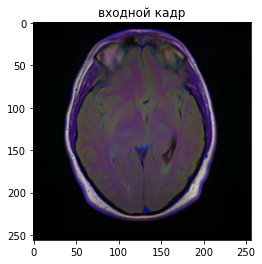

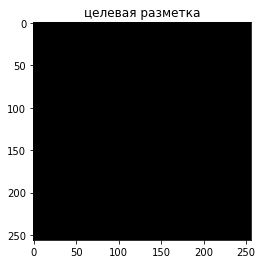

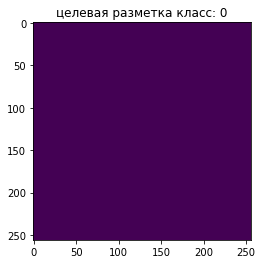

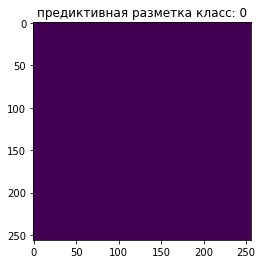

In [117]:
n = 0
class_ = 0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

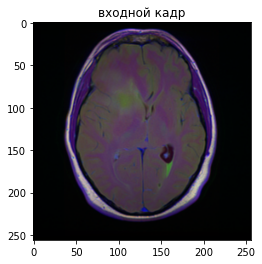

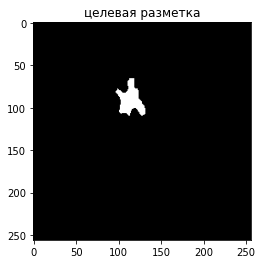

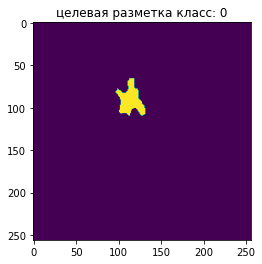

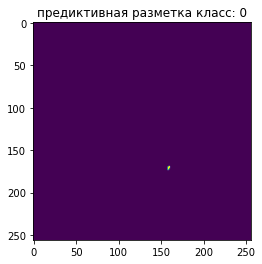

In [118]:
n = 1
class_ = 0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

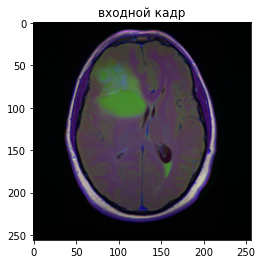

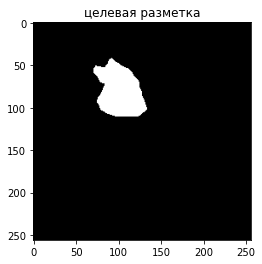

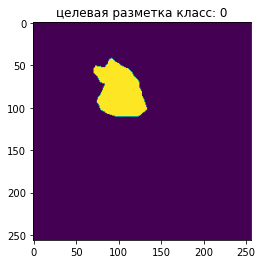

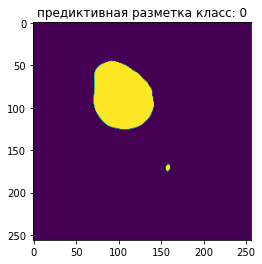

In [119]:
n = 2
class_ = 0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

Вывод: Unet может решить задачу на медицинскую тематику

<p>Были произведены слкдующие действия с данными:<p/>
<p>1. Загрузка изображений и информации о пациентах<p/>
<p>2. Заполнение ненайденных данных -1<p/>
<p>3. Добавление данныйх о пациенте к каждой из изображений. <p/>
<p>4. Тренировка нейронной сети для фильтрации изображений с 78% точностью.<p/>
<p>5. Фильтрация незначемых изображений<p/>
<p>6. Тренировка нейронной сети для сегментации изображения для нахождения опухолей.<p/>
<p>7. Вывод результатов работы нейронной сети.<p/>